In [1]:
import sys
from os.path import join, abspath
from glob import glob
import numpy as np
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm, skewnorm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import simps

In [2]:
# import utils
root_dir = abspath(join('..'))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/6_Analisis',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import style, hdi, find_max, load_spectral_types, inv_simple, inv_standard

In [5]:
sp = load_spectral_types()
sp

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [6]:
style(name="seaborn-notebook")

In [7]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [8]:
data_baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

In [9]:
eff_vol = glob(join(root_data_dir, 'Effective-Volume-no', "z*"))
eff_vol.sort()
eff_vol

['/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(-0.10)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.10)_(0.16).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.16)_(0.20).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.20)_(0.23).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.23)_(0.26).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.26)_(0.28).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.28)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.30)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.34)_(0.36).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.36)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.37)_(0.39).hdf5',
 '/home2/s20321

In [10]:
import re
c1, c2 = [], []
# get the value between () of the file name
for f in eff_vol:
    c1.append(float(re.findall(r'\((.*?)\)', f)[0]))
    c2.append(float(re.findall(r'\((.*?)\)', f)[1]))
c1 = np.array(c1)
c2 = np.array(c2)
c = 0.5*(c1+c2)
c

array([0.   , 0.13 , 0.18 , 0.215, 0.245, 0.27 , 0.29 , 0.31 , 0.33 ,
       0.35 , 0.365, 0.38 , 0.395])

In [11]:
mcmc_dm_dir = join(root_data_dir, "MCMC-no", "mond", "data")
mcmc_dm_dir

'/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data'

In [12]:
mond_2_files = glob(join(mcmc_dm_dir, "chain-2-*"))
mond_2_files.sort()
mond_2_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-00.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-01.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-02.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-03.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-04.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-05.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-06.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-07.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-08.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-09.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-10.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-11.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-12.npy']

In [16]:
# import os
# for i in range(len(mond_2_files)):
#     oldname = join(mcmc_dm_dir, f"chain-2-{i}.npy")
#     print("old:", oldname)
#     newname = join(mcmc_dm_dir, f"chain-2-{i:02d}.npy")
#     print("new:", newname)
#     os.rename(oldname, newname)

old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-0.npy
new: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-00.npy
old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-1.npy
new: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-01.npy
old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-2.npy
new: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-02.npy
old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-3.npy
new: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-03.npy
old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-4.npy
new: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-04.npy
old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-5.npy
new: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-05.npy
old: /home2/s20321005/Thesis-Project/Data/MCMC-no/mond/data/chain-2-6.npy
new: /home2/s20321005/Thesis-Pro

## tes

In [16]:
index = 2
df = np.load(join(mcmc_dm_dir, f"chain-2-{index:02d}.npy"))
df.shape

(20000, 68, 33)

In [17]:
rhob = df[:, :, :12]
rhob = rhob.reshape(-1, 12)
rhob = rhob.sum(axis=1)/1E-2
length = len(rhob)
mu0 = df[:, :, 24].reshape(-1)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2

rhoD = rhob*(1/mu0-1)

# plot

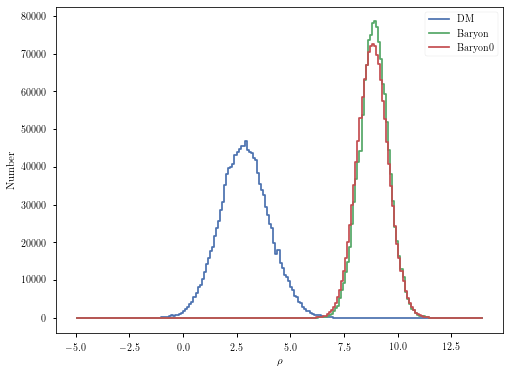

In [18]:
rho = np.linspace(-5, 14, 200)
rhoD_num, _ = np.histogram(rhoD, bins=rho)
rhob_num, _ = np.histogram(rhob, bins=rho)
rhob0_num, _ = np.histogram(rhob0, bins=rho)
rhomid = 0.5*(rho[1:] + rho[:-1])
# plot step
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(rhomid, rhoD_num, label='DM')
ax.step(rhomid, rhob_num, label='Baryon')
ax.step(rhomid, rhob0_num, label='Baryon0')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Number')
ax.legend()
plt.show()

In [19]:
rhoD_sample = np.random.choice(rhoD, size=2000, replace=False)
rhoD_fit = skewnorm.fit(rhoD_sample)
rhob_sample = np.random.choice(rhob, size=2000, replace=False)
rhob_fit = skewnorm.fit(rhob_sample)
rhob0_sample = np.random.choice(rhob0, size=2000, replace=False)
rhob0_fit = norm.fit(rhob0_sample)

((0.915047364104339, 2.2258301431519305, 1.351281963067849),
 (-0.975593128255799, 9.377472593164185, 0.8210030513857672),
 (8.865606960128884, 0.72722369716554))

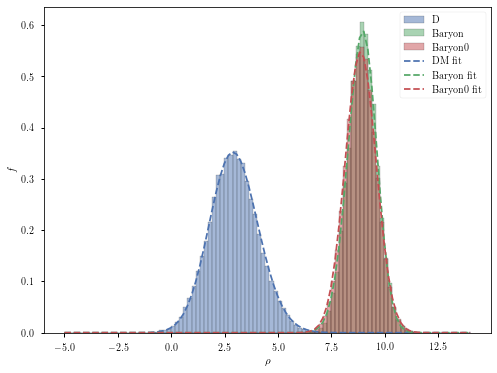

In [20]:
# plot
rho = np.linspace(-5, 14, 100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoD, bins=rho, density=True, label='D', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoD_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
rhoD_fit, rhob_fit, rhob0_fit

rhoDM = 2.89 +1.15/-1.12
rhob = 8.97 +0.66/-0.69
rhob0 = 8.87 +0.74/-0.72


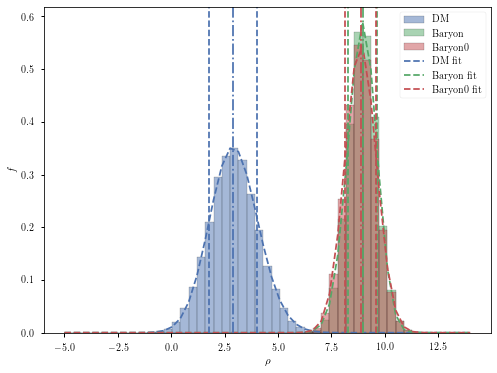

In [21]:
rhoD_low, rhoD_high = hdi(lambda x: skewnorm.pdf(x, *rhoD_fit), perc=0.68, res=1E3, min=-5, max=14)
rhoD_mode = find_max(lambda x: skewnorm.pdf(x, *rhoD_fit), x0=0.0)[0]

rhob_low, rhob_high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]

rhob0_low, rhob0_high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=0.68, res=1E3, min=-5, max=14)
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]

# plot
rho = np.linspace(-5, 14, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhoD, bins=rho, density=True, label='DM', ec='k', alpha=0.5, color='C0')
ax.hist(rhob, bins=rho, density=True, label='Baryon', ec='k', alpha=0.5,color='C1')
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, skewnorm.pdf(rho, *rhoD_fit), label='DM fit', color='C0',  ls='--')
ax.plot(rho, skewnorm.pdf(rho, *rhob_fit), label='Baryon fit', color='C1', ls='--')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhoD_mode, color='C0', ls='-.')
ax.axvline(rhob_mode, color='C1', ls='-.')
ax.axvline(rhob0_mode, color='C2', ls='-.')
ax.axvline(rhoD_low, color='C0', ls='--')
ax.axvline(rhoD_high, color='C0', ls='--')
ax.axvline(rhob_low, color='C1', ls='--')
ax.axvline(rhob_high, color='C1', ls='--')
ax.axvline(rhob0_low, color='C2', ls='--')
ax.axvline(rhob0_high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhoDM = {rhoD_mode:.02f} +{rhoD_high-rhoD_mode:.02f}/-{rhoD_mode-rhoD_low:.02f}')
print(f'rhob = {rhob_mode:.02f} +{rhob_high-rhob_mode:.02f}/-{rhob_mode-rhob_low:.02f}')
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low:.02f}')

rhob0 = 8.89 +0.71/-0.71


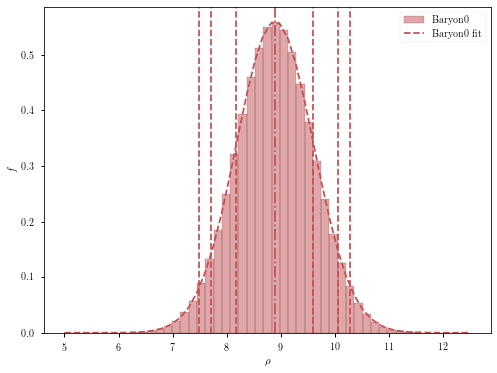

In [22]:
length = len(rhob)
rhob0 = np.empty((length, 12))
for i in range(12):
    rhob0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob0 = rhob0.sum(axis=1)/1E-2
# fit with gaussian
rhob0_fit = norm.fit(rhob0)
# mode
rhob0_mode = find_max(lambda x: norm.pdf(x, *rhob0_fit), x0=0.0)[0]
# find 
sigma_1 = 68/100
sigma_2 = 90/100
sigma_3 = 95/100
rhob0_low = {}
rhob0_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: norm.pdf(x, *rhob0_fit), perc=sigma, res=1E3, min=5, max=13)
    rhob0_low[i] = low
    rhob0_high[i] = high
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(rhob0_mode, color='C2', ls='-.')
for i in range(3):
    ax.axvline(rhob0_low[i], color='C2', ls='--')
    ax.axvline(rhob0_high[i], color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f'rhob0 = {rhob0_mode:.02f} +{rhob0_high[0]-rhob0_mode:.02f}/-{rhob0_mode-rhob0_low[0]:.02f}')

In [23]:
from tqdm import tqdm

rhoD_modes = []
rhoD_errs = []
rhob_modes = []
rhob_errs = []
rhoD_fits = []

for index in tqdm(range(len(mond_2_files))):
    df = np.load(mond_2_files[index])
    rhob = df[:, :, :12]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    mu0 = df[:, :, 24].reshape(-1)
    rhoD = rhob*(1/mu0-1)
    print("fitting...")
    rhoD_sample = np.random.choice(rhoD, size=2000, replace=False)
    rhoD_fit = skewnorm.fit(rhoD_sample)
    rhoD_fits.append(rhoD_fit)
    rhob_sample = np.random.choice(rhob, size=2000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)
    print("calculating HDI...")
    rhoD_low = {}
    rhoD_high = {}
    rhob_low = {}
    rhob_high = {}
    for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhoD_fit), perc=sigma, res=1E3, min=-5, max=15)
        rhoD_low[i] = low
        rhoD_high[i] = high
        low, high = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), perc=sigma, res=1E3, min=5, max=13)
        rhob_low[i] = low
        rhob_high[i] = high
    print("calculating mode")
    rhoD_mode = find_max(lambda x: skewnorm.pdf(x, *rhoD_fit), x0=0.0)[0]
    rhob_mode = find_max(lambda x: skewnorm.pdf(x, *rhob_fit), x0=0.0)[0]
    rhoD_modes.append(rhoD_mode)
    rhoD_errs.append({'low': rhoD_low, 'high': rhoD_high})
    rhob_modes.append(rhob_mode)
    rhob_errs.append({'low': rhob_low, 'high': rhob_high})

  0%|          | 0/13 [00:00<?, ?it/s]

fitting...
calculating HDI...


  8%|▊         | 1/13 [00:04<00:49,  4.15s/it]

calculating mode
fitting...
calculating HDI...


 15%|█▌        | 2/13 [00:08<00:46,  4.24s/it]

calculating mode
fitting...
calculating HDI...


 23%|██▎       | 3/13 [00:10<00:33,  3.36s/it]

calculating mode
fitting...
calculating HDI...


 31%|███       | 4/13 [00:15<00:33,  3.74s/it]

calculating mode
fitting...
calculating HDI...


 38%|███▊      | 5/13 [00:19<00:31,  3.91s/it]

calculating mode
fitting...
calculating HDI...


 46%|████▌     | 6/13 [00:23<00:27,  3.98s/it]

calculating mode
fitting...
calculating HDI...


 54%|█████▍    | 7/13 [00:27<00:24,  4.03s/it]

calculating mode
fitting...
calculating HDI...


 62%|██████▏   | 8/13 [00:31<00:20,  4.16s/it]

calculating mode
fitting...
calculating HDI...


 69%|██████▉   | 9/13 [00:36<00:17,  4.33s/it]

calculating mode
fitting...
calculating HDI...


 77%|███████▋  | 10/13 [00:40<00:12,  4.27s/it]

calculating mode
fitting...
calculating HDI...


 85%|████████▍ | 11/13 [00:45<00:08,  4.35s/it]

calculating mode
fitting...
calculating HDI...


 92%|█████████▏| 12/13 [00:49<00:04,  4.19s/it]

calculating mode
fitting...
calculating HDI...


100%|██████████| 13/13 [00:53<00:00,  4.13s/it]

calculating mode


In [24]:
rhoD_fits

[(0.9753864141021488, 0.04599514788383412, 1.165237242120705),
 (0.7955175310970983, 1.3597336091115049, 1.5416908299740932),
 (1.0846840936520965, 2.0844550259477455, 1.4389906795134788),
 (0.7693530950358147, 4.018517693384458, 1.3116916831722838),
 (1.0740618622363352, 5.654545648720043, 1.6479987308779962),
 (1.2939551573253243, 3.137144717408934, 1.740724828642258),
 (1.402835115470279, 1.5949113805789388, 1.4484353517847937),
 (-1.2879162015191055, 1.8833293250013492, 1.4315142482997116),
 (-2.17846356167588, 2.2947065201152963, 1.890697686624646),
 (-0.5186590337807975, 0.642407282904202, 1.0474901581102827),
 (0.9244839131937765, -0.43734452318242956, 1.3047295049086363),
 (0.6624804948178713, -0.05018811171464989, 1.0286759810193318),
 (-1.3032353804117318, 2.908171724567815, 1.948688140815304)]

(0.0, 5.0)

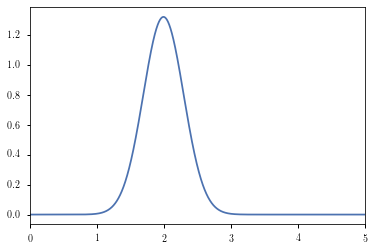

In [33]:
# multiplying the rhoDM, but it became addition in log
rho = np.linspace(-5, 14, 10000)
log_rhoD = None
for p in rhoD_fits:
    if log_rhoD is None:
        log_rhoD = skewnorm.logpdf(rho, *p)
    else:
        log_rhoD += skewnorm.logpdf(rho, *p)
# turn into rhoDM
rhoD_com = np.exp(log_rhoD)
# find area
area = np.trapz(rhoD_com, rho)
# normalize
rhoD_com /= area
# plot
fig, ax = plt.subplots()
ax.plot(rho, rhoD_com, label='rhoD')
ax.set_xlim(0,5)

In [34]:
from scipy.optimize import curve_fit

rhoD_com_fit, _ = curve_fit(skewnorm.pdf, rho, rhoD_com, p0=[1, 1.0, 2.0])
rhoD_com_fit

array([0.24119146, 1.92989564, 0.30694197])

(0.0, 5.0)

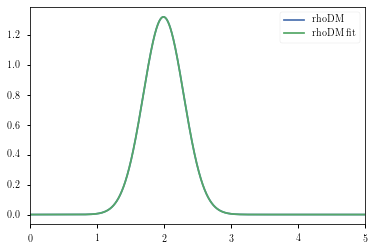

In [36]:
plt.plot(rho, rhoD_com, label='rhoDM')
plt.plot(rho, skewnorm.pdf(rho, *rhoD_com_fit), label='rhoDM fit')
plt.legend()
plt.xlim(0,5)

In [37]:
rhoD_com_low = {}
rhoD_com_high = {}
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: skewnorm.pdf(x, *rhoD_com_fit), perc=sigma, res=1E3, min=0, max=5)
    rhoD_com_low[i] = low
    rhoD_com_high[i] = high
rhoD_com_mode = find_max(lambda x: skewnorm.pdf(x, *rhoD_com_fit), x0=0.0)[0]

In [38]:
rhoD_com_mode, rhoD_com_low, rhoD_com_high

(1.9868750000000024,
 {0: 1.6866866866866868, 1: 1.4914914914914914, 2: 1.3963963963963963},
 {0: 2.2872872872872874, 1: 2.4874874874874875, 2: 2.5825825825825826})

In [39]:
A9 = sp[sp['SpT'] == 'A9V']['J-K'].values[0]
F0 = sp[sp['SpT'] == 'F0V']['J-K'].values[0]
b1 = (A9+F0)/2

F9 = sp[sp['SpT'] == 'F9V']['J-K'].values[0]
G0 = sp[sp['SpT'] == 'G0V']['J-K'].values[0]
b2 = (F9+G0)/2
b1, b2

(0.1355, 0.314)

In [31]:
for i in range(len(c)):
    print(r"${}\leq c < {}$ & {:.02f} & [{:.02f},{:.02f}] & [{:.02f},{:.02f}] & [{:.02f},{:.02f}] \\".format(c1[i], c2[i], rhoDM_mode[i], rhoDM_low68[i], rhoDM_high68[i], rhoDM_low90[i], rhoDM_high90[i], rhoDM_low95[i], rhoDM_high95[i]))

$-0.1\leq c < 0.04$ & 0.87 & [-0.44,2.34] & [-1.23,3.41] & [-1.60,3.94] \\
$0.04\leq c < 0.1$ & 1.54 & [0.34,2.87] & [-0.40,3.82] & [-0.74,4.30] \\
$0.1\leq c < 0.14$ & 1.92 & [0.61,3.39] & [-0.21,4.43] & [-0.59,4.95] \\
$0.14\leq c < 0.18$ & 0.75 & [-0.23,1.77] & [-0.82,2.49] & [-1.12,2.84] \\
$0.18\leq c < 0.21$ & 3.70 & [2.76,4.66] & [2.15,5.29] & [1.85,5.59] \\
$0.21\leq c < 0.24$ & 4.77 & [3.77,5.75] & [3.12,6.39] & [2.80,6.70] \\
$0.24\leq c < 0.27$ & 3.59 & [2.70,4.49] & [2.15,5.10] & [1.88,5.38] \\
$0.27\leq c < 0.29$ & 1.87 & [1.11,2.74] & [0.63,3.35] & [0.42,3.67] \\
$0.29\leq c < 0.32$ & 1.50 & [0.78,2.25] & [0.33,2.76] & [0.10,2.99] \\
$0.32\leq c < 0.34$ & 0.77 & [0.14,1.41] & [-0.28,1.81] & [-0.49,2.02] \\
$0.34\leq c < 0.36$ & 0.79 & [0.15,1.43] & [-0.25,1.85] & [-0.44,2.06] \\
$0.36\leq c < 0.38$ & 1.04 & [0.44,1.68] & [0.08,2.13] & [-0.09,2.36] \\
$0.38\leq c < 0.4$ & 0.77 & [0.12,1.47] & [-0.28,1.96] & [-0.47,2.21] \\


In [40]:
c

array([0.   , 0.13 , 0.18 , 0.215, 0.245, 0.27 , 0.29 , 0.31 , 0.33 ,
       0.35 , 0.365, 0.38 , 0.395])

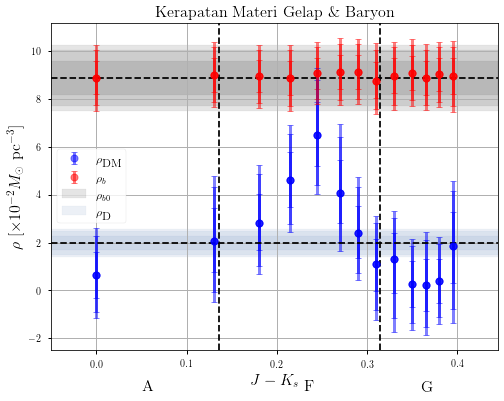

1.9868750000000024

In [42]:
cs = np.linspace(c.min()-0.05, c.max()+0.05, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=rhob0_mode, color='black', linestyle='--')
for i in range(3):
    low = np.array([err['low'][i] for err in rhoD_errs])
    high = np.array([err['high'][i] for err in rhoD_errs])
    dm_ax = ax.errorbar(c, rhoD_modes, yerr=[rhoD_modes-low, high-rhoD_modes], fmt='o', color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([err['low'][i] for err in rhob_errs])
    high = np.array([err['high'][i] for err in rhob_errs])
    rhob_ax = ax.errorbar(c, rhob_modes, yerr=[rhob_modes-low, high-rhob_modes], fmt='o', color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    rhob0_ax = ax.fill_between(cs, rhob0_low[i], rhob0_high[i], color='black', alpha=0.1)
    rhoD_com_ax = ax.fill_between(cs, rhoD_com_low[i], rhoD_com_high[i], color='C0', alpha=0.1)
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob0_ax, rhoD_com_ax], 
                  [r'$\rho_{\textup{DM}}$', r'$\rho_{b}$', r'$\rho_{b0}$', r'$\rho_{\textup{D}}$'],
                  loc='best', fontsize=12)
# real value
ax.axhline(y=rhoD_com_mode, color='black', linestyle='--')
ax.axvline(x=b1, color='black', linestyle='--')
ax.axvline(x=b2, color='black', linestyle='--')
ax.text(0.05, -4.2, r'$\textup{A}$', fontsize=16)
ax.text(0.23, -4.2, r'$\textup{F}$', fontsize=16)
ax.text(0.36, -4.2, r'$\textup{G}$', fontsize=16)
ax.set_xlabel(r'$J-K_s$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_xlim(cs.min(), cs.max())
ax.set_title("Kerapatan Materi Gelap \& Baryon", fontsize=16)
ax.grid()
fig.savefig(join('img', 'rhoD-mond.pdf'), dpi=300)
plt.show()
rhoD_com_mode

# $a_0$

interpolation function
**Simple**
\begin{aligned}
    \mu(x) = \frac{x}{1+x}
\end{aligned}

**Standard**
\begin{aligned}
    \mu(x) = \sqrt{\frac{x^2}{1+x^2}}
\end{aligned}

## Inverse

**Simple**
\begin{equation*}
    x = \frac{\mu}{1-\mu}
\end{equation*}

**Standard**
\begin{equation*}
    x = \frac{\mu}{\sqrt{1-\mu^2}}
\end{equation*}

In [13]:
from utils import inv_simple, inv_standard, simple, standard

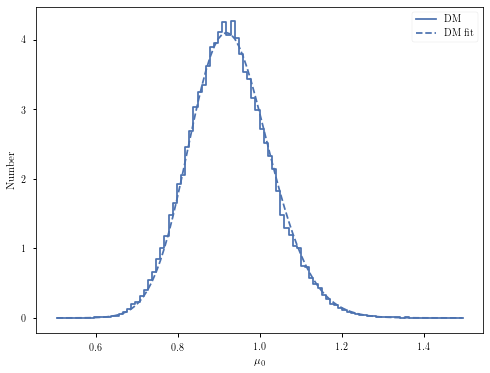

0.9999990387147385

In [14]:
index = 0
df = np.load(join(mcmc_dm_dir, f"chain-2-{index:02d}.npy"))
mu0 = df[:, :, 24].reshape(-1)

# plot mu0 histogram
mu0s_edge = np.linspace(0.5, 1.5, 100)
mu0s = 0.5*(mu0s_edge[1:] + mu0s_edge[:-1])
mu0_num, _ = np.histogram(mu0, bins=mu0s_edge)
area = mu0_num.sum()*np.diff(mu0s_edge)[0]
mu0_num = mu0_num/area

# fit with skew normal
mu0_sample = np.random.choice(mu0, size=10000, replace=False)
mu0_fit = skewnorm.fit(mu0_sample)

# plot  step
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(mu0s, mu0_num, label='DM')
ax.plot(mu0s, skewnorm.pdf(mu0s, *mu0_fit), label='DM fit', color='C0',  ls='--')
ax.set_xlabel(r'$\mu_0$')
ax.set_ylabel('Number')
ax.legend()
plt.show()

simps(skewnorm.pdf(mu0s, *mu0_fit), mu0s)

Transform $\mu_0$ to $x$, where $x=a/a_0$

\begin{align*}
    f_x \text{d}x &= f_\mu \text{d}\mu \\
    f_x &= f_\mu \left(\frac{\text{d}x}{\text{d}\mu}\right)^{-1}
\end{align*}

**simple**

\begin{align*}
    \mu &= \frac{x}{1+x} \\
    x &= \frac{\mu}{1-\mu} \\
    \frac{\text{d}x}{\text{d}\mu} &= \frac{1}{(1-\mu)^2} \\
    \Rightarrow f_x &= f_\mu (1-\mu)^2
\end{align*}

**standard**

\begin{align*}
    \mu &= \frac{x}{\sqrt{1+x^2}} \\
    x &= \frac{\mu}{\sqrt{1-\mu^2}} \\
    \frac{\text{d}x}{\text{d}\mu} &= \frac{1}{(1-\mu^2)^{3/2}} \\
    \Rightarrow f_x &= f_\mu (1-\mu^2)^{3/2}
\end{align*}

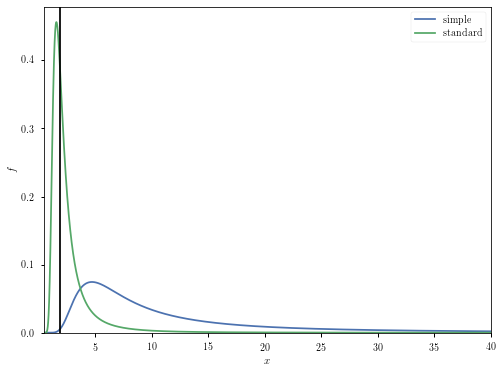

In [15]:
from scipy.integrate import quad

def fx_simple(x, *args):
    mu = simple(x)
    return skewnorm.pdf(mu, *args)*(1-mu)**2

def fx_standard(x, *args):
    mu = standard(x)
    return skewnorm.pdf(mu, *args)*(1-mu**2)**(3/2)

# plot
x = np.linspace(0, 40, 10000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, fx_simple(x, *mu0_fit), label='simple')
ax.plot(x, fx_standard(x, *mu0_fit), label='standard')
ax.axvline(1.87, c='k')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f$')
ax.legend()
# ax.set_xscale('log')
ax.set_ylim(0)
ax.set_xlim(0.5, x.max())
plt.show()

# x_up = np.linspace(40, 50000, 20)
# integral = []
# for x in x_up:
#     integral.append(quad(fx_simple, 0, x, args=mu0_fit)[0])
# integral = np.array(integral)
# # plot
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(x_up, integral, label='simple')
# ax.axvline(1.87, c='k')
# ax.set_xlabel(r'$x$')
# ax.set_ylabel(r'$f$')
# ax.legend()

The value of $a=(2.24\pm0.02)\times 10^{-10} \text{ m s}^{-2}$. 

For $a=1.2\times 10^{-10} \text{ m s}^{-2}$, therefore $x\approx1.87\times 10^{-10} \text{ m s}^{-2}$

convert $x$ to $a_0$.
\begin{align*}
    f_{a_0}(a_0)\text{d}a_0 &= \int_{x=G(a,a_0)} f_x(x)\text{d}x f_a(a)\text{d}a
\end{align*}

Where
\begin{align*}
    x = G(a,a_0) \\
    \text{d}x = |\partial_{a_0} G(a,a_0)|\text{d}a_0
\end{align*}

Therefore,
\begin{align*}
    f_{a_0}(a_0) &= \int_{\forall a} f_x\circ G (a,a_0)|\partial_{a_0}G(a,a_0)| f_a(a)\text{d}a
\end{align*}

In this case,
\begin{align*}
    x =G(a,a_0) &= \frac{a}{a_0} \\
    \text{d}x = |\partial_{a_0}G(a,a_0)|\text{d}a_0 &=  \frac{a}{a_0^2}\text{d}a_0
\end{align*}

Convert $x$ to $b=1/a_0$. To include the pdf of $a$, we need to make some adjustment.

\begin{align*}
    f_{b}(b)\text{d}b = \int_{b=F(a,x)} f_a(a) \text{d}a f_x(x) \text{d}x
\end{align*}

Therefore
\begin{align*}
    f_{a_0}(a_0) &= \int_{\forall a} f_x\left(\frac{a}{a_0}\right)\left(\frac{a}{a_0^2}\right) f_a(a)\text{d}a
\end{align*}

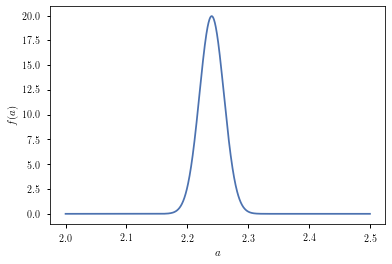

In [16]:
def f_a(a, loc, scale):
    return norm.pdf(a, loc, scale)

a = np.linspace(2, 2.5, 1000)
f_a_sample = f_a(a, 2.24, 0.02)

plt.plot(a, f_a_sample)
plt.xlabel(r'$a$')
plt.ylabel(r'$f(a)$')
plt.show()

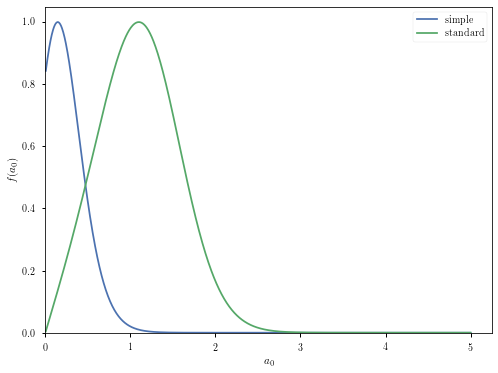

In [47]:
from scipy.integrate import simps

def G(a,a0):
    with np.errstate(divide='ignore'):
        return np.select([a0>0], [a/a0], default=np.nan)

def deriv_G(a,a0):
    with np.errstate(divide='ignore'):
        return np.select([a0>0], [a/a0**2], default=np.nan)

def f_a0_simple(a0, loc, scale, res, *args):
    a = np.linspace(2.1, 2.4, res)
    A, A0 = np.meshgrid(a, a0)
    X = G(A,A0)
    integrand = fx_simple(X, *args)*deriv_G(A, A0)*f_a(A, loc, scale)
    integral = simps(integrand, a, axis=1)
    # normalize to area of 1
    # area = simps(integral, a0)
    # integral /= area
    return np.select([a0>0], [integral], default=0)

def f_a0_standard(a0, loc, scale, res, *args):
    a = np.linspace(2.1, 2.4, res)
    A, A0 = np.meshgrid(a, a0)
    X = G(A,A0)
    integrand = fx_standard(X, *args)*deriv_G(A, A0)*f_a(A, loc, scale)
    integral = simps(integrand, a, axis=1)
    # normalize to area of 1
    # area = simps(integral, a0)
    # integral /= area
    return np.select([a0>0], [integral], default=0)

a0 = np.linspace(0, 5, 1000)
# remove the first element of a0
a0 = a0[1:]
loc = 2.24
scale = 0.02

f_a0_simple_sample = f_a0_simple(a0, loc, scale, 1000, *mu0_fit)
# normalize to max value
f_a0_simple_sample /= f_a0_simple_sample.max()
f_a0_standard_sample = f_a0_standard(a0, loc, scale, 1000,*mu0_fit)
# normalize to max value
f_a0_standard_sample /= f_a0_standard_sample.max()

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(a0, f_a0_simple_sample, label='simple')
ax.plot(a0, f_a0_standard_sample, label='standard')
ax.set_xlabel(r'$a_0$')
ax.set_ylabel(r'$f(a_0)$')
ax.legend()
ax.set_xlim(0)
ax.set_ylim(0)
plt.show()

In [20]:
from scipy import integrate

def hdi(func, perc=0.68, res=1E3, min=0.0, max=1.0):
  r""" Highest density interval of {perc}% of normalized distribution
  perc: percentile
  res: resolution, number of sampling from distributiion
  min: min x-value
  max: max x-value
  """
  x = np.linspace(min, max, int(res))
  # normalize func to 1
  area, _ = integrate.quad(func, a=min, b=max)
  y = func(x)/area
  upper = np.max(y)*0.99
  below = 0
  for k in range(10):
    ys = np.linspace(upper, below, 10)
    for i in range(10):
      mask = y > ys[i]
      x_mask = x[mask]
      integral, _ = integrate.quad(func, a=x_mask[0], b=x_mask[-1])
      if(integral > perc): break
    upper = ys[i-1]
    below = ys[i]
    xMin = x_mask[0]
    xMax = x_mask[-1]
  return (xMin, xMax)

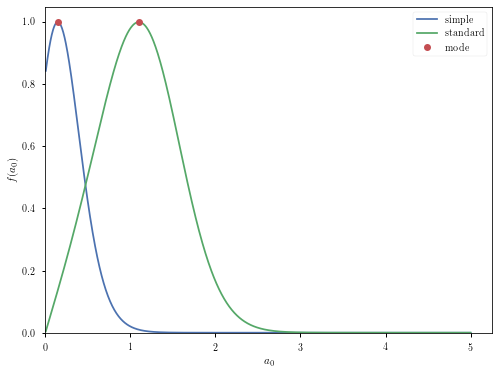

(0.14531249999999923, 1.0989257812500002)

In [49]:
a0_simple_mode = find_max(lambda a0: f_a0_simple(a0, loc, scale, 100, *mu0_fit), x0=1)[0]
a0_standard_mode = find_max(lambda a0: f_a0_standard(a0, loc, scale, 100, *mu0_fit), x0=1)[0]
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(a0, f_a0_simple_sample, label='simple')
ax.plot(a0, f_a0_standard_sample, label='standard')
ax.plot([a0_simple_mode, a0_standard_mode], [1, 1], 'o', label='mode')
ax.set_xlabel(r'$a_0$')
ax.set_ylabel(r'$f(a_0)$')
ax.legend()
ax.set_xlim(0)
ax.set_ylim(0)
plt.show()

a0_simple_mode, a0_standard_mode

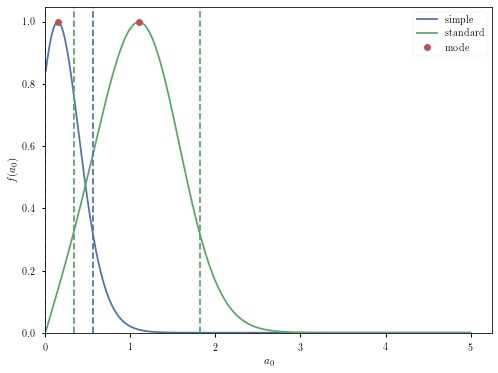

simple 0.0005000500050005 0.562056205620562
standard 0.33103310331033103 1.8131813181318133


In [54]:
a0_simple_low, a0_simple_high = hdi(lambda a0: f_a0_simple(a0, loc, scale, 200, *mu0_fit), perc=0.68, res=1E4, min=0, max=5)
a0_standard_low, a0_standard_high = hdi(lambda a0: f_a0_standard(a0, loc, scale, 200, *mu0_fit), perc=0.68, res=1E4, min=0, max=5)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(a0, f_a0_simple_sample, label='simple')
ax.plot(a0, f_a0_standard_sample, label='standard')
ax.plot([a0_simple_mode, a0_standard_mode], [1, 1], 'o', label='mode')
ax.axvline(a0_simple_low, color='C0', ls='--')
ax.axvline(a0_simple_high, color='C0', ls='--')
ax.axvline(a0_standard_low, color='C1', ls='--')
ax.axvline(a0_standard_high, color='C1', ls='--')
ax.set_xlabel(r'$a_0$')
ax.set_ylabel(r'$f(a_0)$')
ax.legend()
ax.set_xlim(0)
ax.set_ylim(0)
plt.show()

print("simple", a0_simple_low, a0_simple_high)
print("standard", a0_standard_low, a0_standard_high)

### automation

  0%|          | 0/13 [00:00<?, ?it/s]

find hdi 0.68
find hdi 0.9
find hdi 0.95


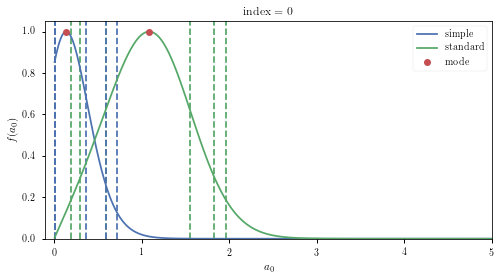

  8%|▊         | 1/13 [00:09<01:50,  9.22s/it]

index = 0
mu0_fit [1.18626185 0.85686596 0.12356051]
simple
	mode = 0.14
	err
		sigma = 0.68, low = 0.01, high = 0.37
		sigma = 0.90, low = 0.01, high = 0.59
		sigma = 0.95, low = 0.01, high = 0.72
standard
	mode = 1.09
	err
		sigma = 0.68, low = 0.60, high = 1.55
		sigma = 0.90, low = 0.30, high = 1.83
		sigma = 0.95, low = 0.19, high = 1.97
find hdi 0.68
find hdi 0.9
find hdi 0.95


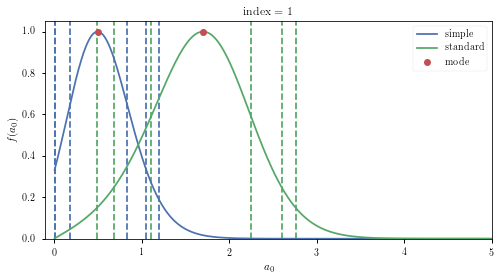

 15%|█▌        | 2/13 [00:18<01:43,  9.37s/it]

index = 1
mu0_fit [1.78613901 0.71350402 0.14733412]
simple
	mode = 0.50
	err
		sigma = 0.68, low = 0.18, high = 0.84
		sigma = 0.90, low = 0.01, high = 1.05
		sigma = 0.95, low = 0.01, high = 1.20
standard
	mode = 1.70
	err
		sigma = 0.68, low = 1.11, high = 2.25
		sigma = 0.90, low = 0.68, high = 2.60
		sigma = 0.95, low = 0.49, high = 2.76
find hdi 0.68
find hdi 0.9
find hdi 0.95


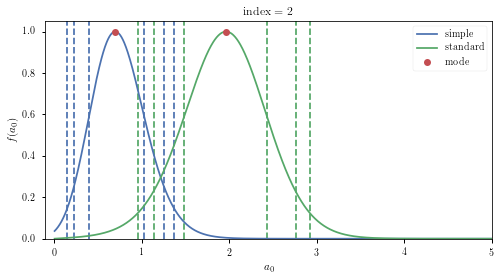

 23%|██▎       | 3/13 [00:30<01:45, 10.51s/it]

index = 2
mu0_fit [1.42381222 0.68885387 0.10596325]
simple
	mode = 0.70
	err
		sigma = 0.68, low = 0.40, high = 1.02
		sigma = 0.90, low = 0.23, high = 1.25
		sigma = 0.95, low = 0.15, high = 1.37
standard
	mode = 1.96
	err
		sigma = 0.68, low = 1.48, high = 2.44
		sigma = 0.90, low = 1.14, high = 2.76
		sigma = 0.95, low = 0.96, high = 2.92
find hdi 0.68
find hdi 0.9
find hdi 0.95


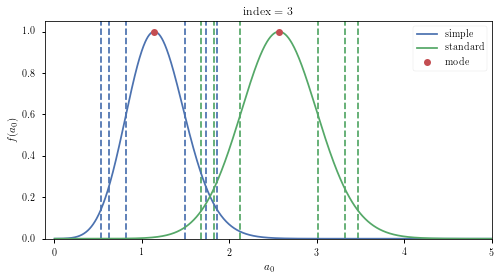

 31%|███       | 4/13 [00:40<01:31, 10.20s/it]

index = 3
mu0_fit [1.49484608 0.60210453 0.08736584]
simple
	mode = 1.14
	err
		sigma = 0.68, low = 0.82, high = 1.49
		sigma = 0.90, low = 0.63, high = 1.74
		sigma = 0.95, low = 0.54, high = 1.86
standard
	mode = 2.57
	err
		sigma = 0.68, low = 2.12, high = 3.01
		sigma = 0.90, low = 1.83, high = 3.32
		sigma = 0.95, low = 1.68, high = 3.47
find hdi 0.68
find hdi 0.9
find hdi 0.95


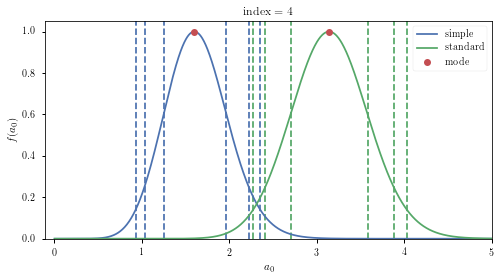

 38%|███▊      | 5/13 [00:50<01:21, 10.20s/it]

index = 4
mu0_fit [1.57934115 0.5332546  0.0740278 ]
simple
	mode = 1.60
	err
		sigma = 0.68, low = 1.25, high = 1.97
		sigma = 0.90, low = 1.04, high = 2.22
		sigma = 0.95, low = 0.94, high = 2.35
standard
	mode = 3.14
	err
		sigma = 0.68, low = 2.70, high = 3.58
		sigma = 0.90, low = 2.41, high = 3.88
		sigma = 0.95, low = 2.27, high = 4.03
find hdi 0.68
find hdi 0.9
find hdi 0.95


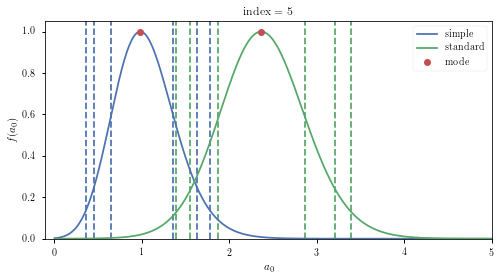

 46%|████▌     | 6/13 [01:00<01:10, 10.01s/it]

index = 5
mu0_fit [1.33279841 0.62605621 0.09805859]
simple
	mode = 0.98
	err
		sigma = 0.68, low = 0.65, high = 1.36
		sigma = 0.90, low = 0.46, high = 1.64
		sigma = 0.95, low = 0.37, high = 1.78
standard
	mode = 2.37
	err
		sigma = 0.68, low = 1.88, high = 2.86
		sigma = 0.90, low = 1.56, high = 3.21
		sigma = 0.95, low = 1.40, high = 3.39
find hdi 0.68
find hdi 0.9
find hdi 0.95


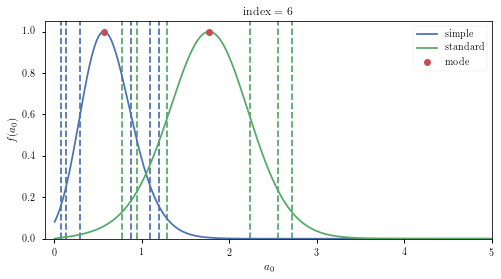

 54%|█████▍    | 7/13 [01:10<01:00, 10.13s/it]

index = 6
mu0_fit [1.22430075 0.72586566 0.10399853]
simple
	mode = 0.57
	err
		sigma = 0.68, low = 0.30, high = 0.88
		sigma = 0.90, low = 0.14, high = 1.09
		sigma = 0.95, low = 0.08, high = 1.20
standard
	mode = 1.77
	err
		sigma = 0.68, low = 1.29, high = 2.24
		sigma = 0.90, low = 0.95, high = 2.56
		sigma = 0.95, low = 0.77, high = 2.72
find hdi 0.68
find hdi 0.9
find hdi 0.95


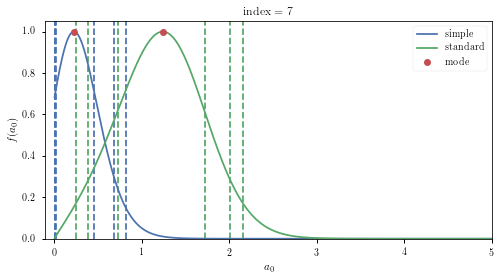

 62%|██████▏   | 8/13 [01:20<00:49,  9.98s/it]

index = 7
mu0_fit [1.34972517 0.81797325 0.12902529]
simple
	mode = 0.23
	err
		sigma = 0.68, low = 0.02, high = 0.46
		sigma = 0.90, low = 0.01, high = 0.69
		sigma = 0.95, low = 0.01, high = 0.82
standard
	mode = 1.24
	err
		sigma = 0.68, low = 0.73, high = 1.72
		sigma = 0.90, low = 0.39, high = 2.01
		sigma = 0.95, low = 0.26, high = 2.15
find hdi 0.68
find hdi 0.9
find hdi 0.95


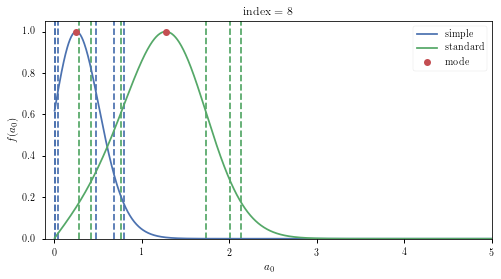

 69%|██████▉   | 9/13 [01:29<00:38,  9.72s/it]

index = 8
mu0_fit [1.52220647 0.80953693 0.12834215]
simple
	mode = 0.25
	err
		sigma = 0.68, low = 0.04, high = 0.48
		sigma = 0.90, low = 0.01, high = 0.68
		sigma = 0.95, low = 0.01, high = 0.80
standard
	mode = 1.28
	err
		sigma = 0.68, low = 0.77, high = 1.74
		sigma = 0.90, low = 0.43, high = 2.01
		sigma = 0.95, low = 0.28, high = 2.14
find hdi 0.68
find hdi 0.9
find hdi 0.95


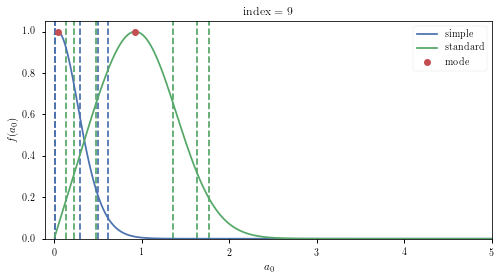

 77%|███████▋  | 10/13 [01:37<00:28,  9.39s/it]

index = 9
mu0_fit [1.36584727 0.89022307 0.13335442]
simple
	mode = 0.04
	err
		sigma = 0.68, low = 0.01, high = 0.29
		sigma = 0.90, low = 0.01, high = 0.50
		sigma = 0.95, low = 0.01, high = 0.62
standard
	mode = 0.93
	err
		sigma = 0.68, low = 0.48, high = 1.36
		sigma = 0.90, low = 0.23, high = 1.64
		sigma = 0.95, low = 0.14, high = 1.77
find hdi 0.68
find hdi 0.9
find hdi 0.95


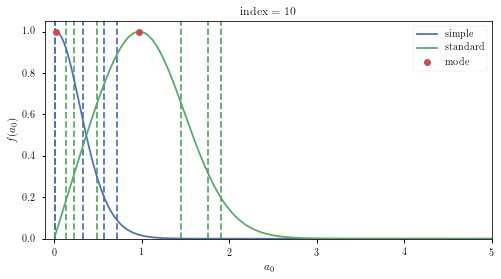

 85%|████████▍ | 11/13 [01:46<00:18,  9.18s/it]

index = 10
mu0_fit [1.71790724 0.86937233 0.17200227]
simple
	mode = 0.02
	err
		sigma = 0.68, low = 0.01, high = 0.33
		sigma = 0.90, low = 0.01, high = 0.57
		sigma = 0.95, low = 0.01, high = 0.72
standard
	mode = 0.97
	err
		sigma = 0.68, low = 0.49, high = 1.45
		sigma = 0.90, low = 0.23, high = 1.76
		sigma = 0.95, low = 0.14, high = 1.91
find hdi 0.68
find hdi 0.9
find hdi 0.95


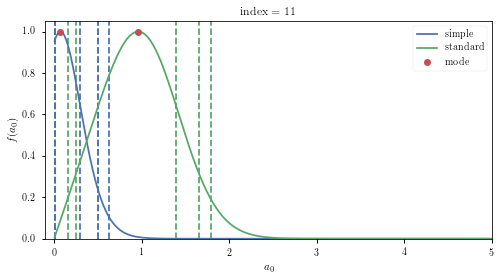

 92%|█████████▏| 12/13 [01:55<00:09,  9.05s/it]

index = 11
mu0_fit [1.24634917 0.88494229 0.12268676]
simple
	mode = 0.07
	err
		sigma = 0.68, low = 0.01, high = 0.30
		sigma = 0.90, low = 0.01, high = 0.51
		sigma = 0.95, low = 0.01, high = 0.63
standard
	mode = 0.96
	err
		sigma = 0.68, low = 0.51, high = 1.39
		sigma = 0.90, low = 0.25, high = 1.66
		sigma = 0.95, low = 0.16, high = 1.79
find hdi 0.68
find hdi 0.9
find hdi 0.95


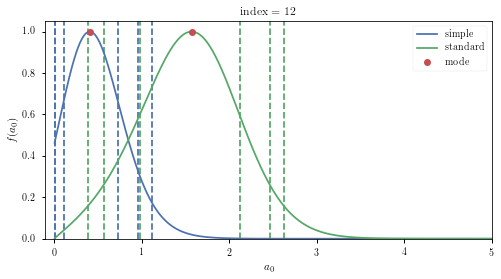

100%|██████████| 13/13 [02:04<00:00,  9.61s/it]

index = 12
mu0_fit [1.72388052 0.73704092 0.15204861]
simple
	mode = 0.41
	err
		sigma = 0.68, low = 0.11, high = 0.73
		sigma = 0.90, low = 0.01, high = 0.96
		sigma = 0.95, low = 0.01, high = 1.12
standard
	mode = 1.57
	err
		sigma = 0.68, low = 0.98, high = 2.12
		sigma = 0.90, low = 0.57, high = 2.46
		sigma = 0.95, low = 0.39, high = 2.63


In [173]:
mu0_fits = []
a0_simple_modes = []
a0_standard_modes = []
a0_simple_errs = []
a0_standard_errs = []

from scipy.stats import skewnorm

def skewpdf(x, *args):
    A, other = args[0], args[1:]
    return A*skewnorm.pdf(x, *other)

sigma_1 = 68/100
sigma_2 = 90/100
sigma_3 = 95/100

for index in tqdm(range(len(mond_2_files))):
    # if index != 2:
    #     continue
    # fit mu0
    df = np.load(join(mcmc_dm_dir, f"chain-2-{index:02d}.npy"))
    mu0 = df[:, :, 24].reshape(-1)

    # plot mu0 histogram
    mu0s_edge = np.linspace(0.5, 1.5, 100)
    mu0s = 0.5*(mu0s_edge[1:] + mu0s_edge[:-1])
    mu0_num, _ = np.histogram(mu0, bins=mu0s_edge)
    area = mu0_num.sum()*np.diff(mu0s_edge)[0]
    mu0_num = mu0_num/area

    # fit with skew normal
    # mu0_sample = np.random.choice(mu0, size=10000, replace=False)
    mu0_fit, _ = curve_fit(skewpdf, mu0s, mu0_num, p0=[1, 1.0, 4.0, 2.0])
    mu0_fit = mu0_fit[1:]
    mu0_fits.append(mu0_fit)
    # plot fa0
    a0 = np.linspace(0, 5, 1000)
    # remove the first element of a0
    a0 = a0[1:]
    loc = 2.24
    scale = 0.02

    f_a0_simple_sample = f_a0_simple(a0, loc, scale, 1000, *mu0_fit)
    # normalize to max value
    f_a0_simple_sample /= f_a0_simple_sample.max()
    f_a0_standard_sample = f_a0_standard(a0, loc, scale, 1000,*mu0_fit)
    # normalize to max value
    f_a0_standard_sample /= f_a0_standard_sample.max()

    a0_simple_mode = find_max(lambda a0: f_a0_simple(a0, loc, scale, 100, *mu0_fit), x0=1)[0]
    a0_simple_modes.append(a0_simple_mode)
    a0_standard_mode = find_max(lambda a0: f_a0_standard(a0, loc, scale, 100, *mu0_fit), x0=1)[0]
    a0_standard_modes.append(a0_standard_mode)
    a0_simple_err = []
    a0_standard_err = []
    fig, ax = plt.subplots(figsize=(8, 4))
    for sigma in [sigma_1, sigma_2, sigma_3]:
        print("find hdi", sigma)
        low, high = hdi(lambda a0: f_a0_simple(a0, loc, scale, 200, *mu0_fit), perc=sigma, res=1E3, min=0, max=5)
        a0_simple_err.append({'sigma': sigma, 'low': low, 'high': high})
        ax.axvline(low, color='C0', ls='--')
        ax.axvline(high, color='C0', ls='--')
        low, high = hdi(lambda a0: f_a0_standard(a0, loc, scale, 200, *mu0_fit), perc=sigma, res=1E3, min=0, max=5)
        a0_standard_err.append({'sigma': sigma, 'low': low, 'high': high})
        ax.axvline(low, color='C1', ls='--')
        ax.axvline(high, color='C1', ls='--')
        # break
    a0_simple_errs.append(a0_simple_err)
    a0_standard_errs.append(a0_standard_err)
    ax.plot(a0, f_a0_simple_sample, label='simple')
    ax.plot(a0, f_a0_standard_sample, label='standard')
    ax.plot([a0_simple_mode, a0_standard_mode], [1, 1], 'o', label='mode')
    
    ax.set_xlabel(r'$a_0$')
    ax.set_ylabel(r'$f(a_0)$')
    ax.legend()
    ax.set_xlim(-0.1,a0.max())
    ax.set_ylim(0)
    ax.set_title(f"index = {index}")
    plt.show()
    print(f"index = {index}")
    print("mu0_fit", mu0_fit)
    print("simple")
    print("\tmode = {:.02f}".format(a0_simple_mode))
    print("\terr")
    for err in a0_simple_err:
        print("\t\tsigma = {:.02f}, low = {:.02f}, high = {:.02f}".format(err['sigma'], err['low'], err['high']))
    print("standard")
    print("\tmode = {:.02f}".format(a0_standard_mode))
    print("\terr")
    for err in a0_standard_err:
        print("\t\tsigma = {:.02f}, low = {:.02f}, high = {:.02f}".format(err['sigma'], err['low'], err['high']))

(0.0, 5.0)

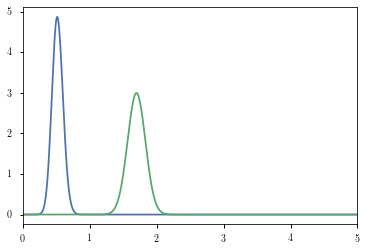

In [174]:
# multiplying the rhoDM, but it became addition in log
a0s = np.linspace(0.01, 5, 1000)
a0_simple_com = None
a0_standard_com = None
for mu0_fit in mu0_fits:
    if a0_simple_com is None:
        a0_simple_com = f_a0_simple(a0s, loc, scale, 200, *mu0_fit)
    else:
        a0_simple_com *= f_a0_simple(a0s, loc, scale, 200, *mu0_fit)
    if a0_standard_com is None:
        a0_standard_com = f_a0_standard(a0s, loc, scale, 200, *mu0_fit)
    else:
        a0_standard_com *= f_a0_standard(a0s, loc, scale, 200, *mu0_fit)
# find area
area = np.trapz(a0_simple_com, a0s)
a0_simple_com /= area
area = np.trapz(a0_standard_com, a0s)
a0_standard_com /= area
# plot
fig, ax = plt.subplots()
ax.plot(a0s, a0_simple_com, label='simple')
ax.plot(a0s, a0_standard_com, label='standard')
ax.set_xlim(0,5)

In [175]:
from scipy.optimize import curve_fit

a0_simple_com_fit, _ = curve_fit(skewnorm.pdf, a0s, a0_simple_com, p0=[1, 1.0, 2.0])
a0_standard_com_fit, _ = curve_fit(skewnorm.pdf, a0s, a0_standard_com, p0=[1, 1.0, 2.0])
a0_simple_com_fit, a0_standard_com_fit

(array([0.95139673, 0.46677516, 0.09855359]),
 array([-0.25724099,  1.72638921,  0.13586063]))

(0.0, 5.0)

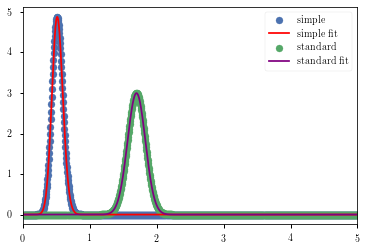

In [176]:
plt.scatter(a0s, a0_simple_com, label='simple')
plt.plot(a0s, skewnorm.pdf(a0s, *a0_simple_com_fit), c='r', label='simple fit')
plt.scatter(a0s, a0_standard_com, label='standard')
plt.plot(a0s, skewnorm.pdf(a0s, *a0_standard_com_fit), c='purple', label='standard fit')
plt.legend()
plt.xlim(0,5)

In [177]:
a0_simple_com_errs = []
a0_standard_com_errs = []
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: skewnorm.pdf(x, *a0_simple_com_fit), perc=sigma, res=1E3, min=0.1, max=5)
    a0_simple_com_errs.append({'sigma': sigma, 'low': low, 'high': high})
    low, high = hdi(lambda x: skewnorm.pdf(x, *a0_standard_com_fit), perc=sigma, res=1E3, min=0.1, max=5)
    a0_standard_com_errs.append({'sigma': sigma, 'low': low, 'high': high})
a0_simple_com_mode = find_max(lambda x: skewnorm.pdf(x, *a0_simple_com_fit), x0=2.0)[0]
a0_standard_com_mode = find_max(lambda x: skewnorm.pdf(x, *a0_standard_com_fit), x0=2.0)[0]

In [178]:
a0_simple_com_mode, a0_simple_com_errs

(0.5158203124999987,
 [{'sigma': 0.68, 'low': 0.4335335335335335, 'high': 0.6003003003003003},
  {'sigma': 0.9, 'low': 0.38448448448448447, 'high': 0.6591591591591591},
  {'sigma': 0.95, 'low': 0.35995995995996, 'high': 0.6836836836836837}])

In [179]:
a0_standard_com_mode, a0_standard_com_errs

(1.6996093749999996,
 [{'sigma': 0.68, 'low': 1.5665665665665667, 'high': 1.8314314314314317},
  {'sigma': 0.9, 'low': 1.4782782782782784, 'high': 1.91971971971972},
  {'sigma': 0.95, 'low': 1.4390390390390393, 'high': 1.9638638638638641}])

In [180]:
a0_simple_errs

[[{'sigma': 0.68, 'low': 0.005005005005005005, 'high': 0.36536536536536535},
  {'sigma': 0.9, 'low': 0.005005005005005005, 'high': 0.5905905905905906},
  {'sigma': 0.95, 'low': 0.005005005005005005, 'high': 0.7207207207207207}],
 [{'sigma': 0.68, 'low': 0.18018018018018017, 'high': 0.8358358358358359},
  {'sigma': 0.9, 'low': 0.01001001001001001, 'high': 1.0460460460460461},
  {'sigma': 0.95, 'low': 0.005005005005005005, 'high': 1.2012012012012012}],
 [{'sigma': 0.68, 'low': 0.40040040040040037, 'high': 1.021021021021021},
  {'sigma': 0.9, 'low': 0.22522522522522523, 'high': 1.2512512512512513},
  {'sigma': 0.95, 'low': 0.15015015015015015, 'high': 1.3713713713713713}],
 [{'sigma': 0.68, 'low': 0.8208208208208209, 'high': 1.4914914914914914},
  {'sigma': 0.9, 'low': 0.6256256256256256, 'high': 1.7367367367367368},
  {'sigma': 0.95, 'low': 0.5355355355355356, 'high': 1.8618618618618619}],
 [{'sigma': 0.68, 'low': 1.2512512512512513, 'high': 1.966966966966967},
  {'sigma': 0.9, 'low': 1.

In [181]:
A9 = sp[sp['SpT'] == 'A9V']['J-K'].values[0]
F0 = sp[sp['SpT'] == 'F0V']['J-K'].values[0]
b1 = (A9+F0)/2

F9 = sp[sp['SpT'] == 'F9V']['J-K'].values[0]
G0 = sp[sp['SpT'] == 'G0V']['J-K'].values[0]
b2 = (F9+G0)/2
b1, b2

(0.1355, 0.314)

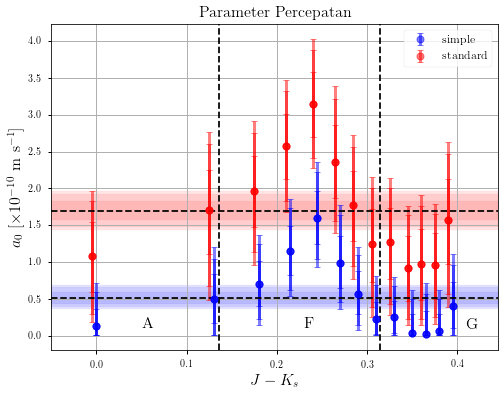

In [186]:
cs = np.linspace(c.min()-0.05, c.max()+0.05, 100)
dc = c2-c1

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    low = np.array([arr[i]['low'] for arr in a0_simple_errs])
    high = np.array([arr[i]['high'] for arr in a0_simple_errs])  
    simple_ax = ax.errorbar(c, a0_simple_modes, yerr=[a0_simple_modes-low, high-a0_simple_modes], fmt='o', 
                        color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([arr[i]['low'] for arr in a0_standard_errs])
    high = np.array([arr[i]['high'] for arr in a0_standard_errs])  
    standard_ax = ax.errorbar(c-0.005, a0_standard_modes, yerr=[a0_standard_modes-low, high-a0_standard_modes], fmt='o', 
                        color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    
    ax.fill_between(cs, a0_simple_com_errs[i]['low'], a0_simple_com_errs[i]['high'], color='blue', alpha=0.1)
    ax.fill_between(cs, a0_standard_com_errs[i]['low'], a0_standard_com_errs[i]['high'], color='red', alpha=0.1)
    if i == 2:
        ax.legend([simple_ax, standard_ax], 
                  ['simple', 'standard'],
                  loc='best', fontsize=12)
# real value
ax.axhline(y=a0_simple_com_mode, color='black', linestyle='--')
ax.axhline(y=a0_standard_com_mode, color='black', linestyle='--')
ax.axvline(x=b1, color='black', linestyle='--')
ax.axvline(x=b2, color='black', linestyle='--')
ax.set_xlabel(r'$J-K_s$', fontsize=16)
ax.set_ylabel(r'$a_0$ [$\times 10^{-10}$ m s$^{-1}$]', fontsize=16)
ax.set_xlim(cs.min(), cs.max())
ax.set_title("Parameter Percepatan", fontsize=16)
ax.text(0.05, 0.1, r'$\textup{A}$', fontsize=16)
ax.text(0.23, 0.1, r'$\textup{F}$', fontsize=16)
ax.text(0.41, 0.1, r'$\textup{G}$', fontsize=16)
ax.grid()
fig.savefig(join('img', 'a0.pdf'), dpi=300)
plt.show()

## no F

In [187]:
a0_simple_errs_nof = np.append(a0_simple_errs[:2], a0_simple_errs[7:], axis=0)
a0_standard_errs_nof = np.append(a0_standard_errs[:2], a0_standard_errs[7:], axis=0)
a0_simple_modes_nof = np.append(a0_simple_modes[:2], a0_simple_modes[7:])
a0_standard_modes_nof = np.append(a0_standard_modes[:2], a0_standard_modes[7:])

In [188]:
mu0_fits = np.array(mu0_fits)

In [189]:
mu0_fits_nof = np.append(mu0_fits[:2], mu0_fits[7:], axis=0)
mu0_fits_nof

array([[1.18626185, 0.85686596, 0.12356051],
       [1.78613901, 0.71350402, 0.14733412],
       [1.34972517, 0.81797325, 0.12902529],
       [1.52220647, 0.80953693, 0.12834215],
       [1.36584727, 0.89022307, 0.13335442],
       [1.71790724, 0.86937233, 0.17200227],
       [1.24634917, 0.88494229, 0.12268676],
       [1.72388052, 0.73704092, 0.15204861]])

(0.0, 5.0)

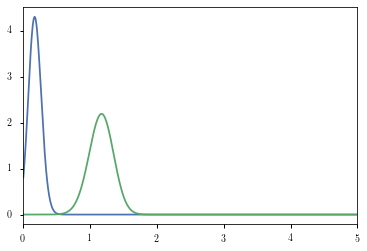

In [190]:
# multiplying the rhoDM, but it became addition in log
a0s = np.linspace(0.01, 5, 1000)
a0_simple_com_nof = None
a0_standard_com_nof = None
mu0_fits_nof = np.append(mu0_fits[:2], mu0_fits[7:], axis=0)
for mu0_fit in mu0_fits_nof:
    if a0_simple_com_nof is None:
        a0_simple_com_nof = f_a0_simple(a0s, loc, scale, 200, *mu0_fit)
    else:
        a0_simple_com_nof *= f_a0_simple(a0s, loc, scale, 200, *mu0_fit)
    if a0_standard_com_nof is None:
        a0_standard_com_nof = f_a0_standard(a0s, loc, scale, 200, *mu0_fit)
    else:
        a0_standard_com_nof *= f_a0_standard(a0s, loc, scale, 200, *mu0_fit)
# find area
area = np.trapz(a0_simple_com_nof, a0s)
a0_simple_com_nof /= area
area = np.trapz(a0_standard_com_nof, a0s)
a0_standard_com_nof /= area
# plot
fig, ax = plt.subplots()
ax.plot(a0s, a0_simple_com_nof, label='simple')
ax.plot(a0s, a0_standard_com_nof, label='standard')
ax.set_xlim(0,5)

In [191]:
from scipy.optimize import curve_fit

def skewpdf_lb(x, lb, *args):
    A, other = args[0], args[1:]
    return np.select([x>lb], [A*skewnorm.pdf(x, *other)], default=0)

a0_simple_com_fit_nof, _ = curve_fit(lambda x, *args: skewpdf_lb(x, 0, *args), a0s, a0_simple_com_nof, p0=[1, 1.0, 2.0, 1.])
a0_standard_com_fit_nof, _ = curve_fit(lambda x, *args: skewpdf_lb(x, 0, *args), a0s, a0_standard_com_nof, p0=[1, 1.0, 2.0, 1.])
a0_simple_com_fit_nof, a0_standard_com_fit_nof

(array([1.03316938, 0.93032088, 0.12177916, 0.11485968]),
 array([ 0.99994265, -0.80030459,  1.27530726,  0.21096847]))

(0.0, 5.0)

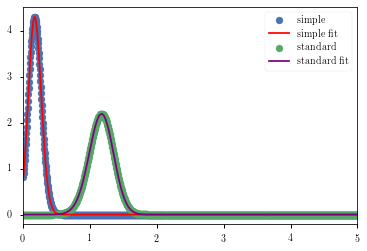

In [192]:
plt.scatter(a0s, a0_simple_com_nof, label='simple')
plt.plot(a0s, skewpdf_lb(a0s, 0, *a0_simple_com_fit_nof), c='r', label='simple fit')
plt.scatter(a0s, a0_standard_com_nof, label='standard')
plt.plot(a0s, skewpdf_lb(a0s, 0, *a0_standard_com_fit_nof), c='purple', label='standard fit')
plt.legend()
plt.xlim(0,5)

In [193]:
a0_simple_com_errs_nof = []
a0_standard_com_errs_nof = []
for i, sigma in enumerate([sigma_1, sigma_2, sigma_3]):
    low, high = hdi(lambda x: skewpdf_lb(x, 0, *a0_simple_com_fit_nof), perc=sigma, res=1E3, min=0.04, max=1)
    a0_simple_com_errs_nof.append({'sigma': sigma, 'low': low, 'high': high})
    low, high = hdi(lambda x: skewpdf_lb(x, 0, *a0_standard_com_fit_nof), perc=sigma, res=1E3, min=0.04, max=2)
    a0_standard_com_errs_nof.append({'sigma': sigma, 'low': low, 'high': high})
a0_simple_com_mode_nof = find_max(lambda x: skewpdf_lb(x, 0, *a0_simple_com_fit_nof), x0=2.0)[0]
a0_standard_com_mode_nof = find_max(lambda x: skewpdf_lb(x, 0, *a0_standard_com_fit_nof), x0=2.0)[0]

In [194]:
a0_simple_errs_nof

array([[{'sigma': 0.68, 'low': 0.005005005005005005, 'high': 0.36536536536536535},
        {'sigma': 0.9, 'low': 0.005005005005005005, 'high': 0.5905905905905906},
        {'sigma': 0.95, 'low': 0.005005005005005005, 'high': 0.7207207207207207}],
       [{'sigma': 0.68, 'low': 0.18018018018018017, 'high': 0.8358358358358359},
        {'sigma': 0.9, 'low': 0.01001001001001001, 'high': 1.0460460460460461},
        {'sigma': 0.95, 'low': 0.005005005005005005, 'high': 1.2012012012012012}],
       [{'sigma': 0.68, 'low': 0.02002002002002002, 'high': 0.45545545545545546},
        {'sigma': 0.9, 'low': 0.005005005005005005, 'high': 0.6856856856856857},
        {'sigma': 0.95, 'low': 0.005005005005005005, 'high': 0.8158158158158159}],
       [{'sigma': 0.68, 'low': 0.04004004004004004, 'high': 0.4754754754754755},
        {'sigma': 0.9, 'low': 0.005005005005005005, 'high': 0.6806806806806807},
        {'sigma': 0.95, 'low': 0.005005005005005005, 'high': 0.8008008008008007}],
       [{'sigma': 

In [195]:
c_nof = np.append(c[:2], c[7:])
c_nof

array([0.   , 0.13 , 0.31 , 0.33 , 0.35 , 0.365, 0.38 , 0.395])

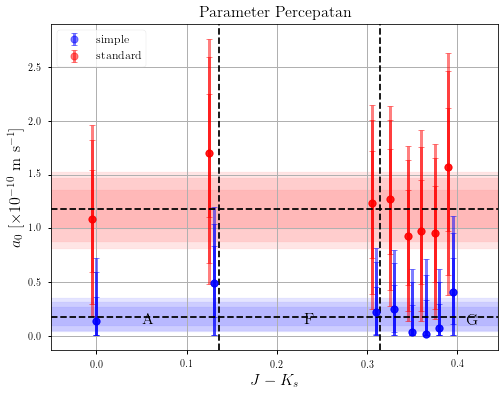

simple
0.18 +0.09 -0.09
0.18 +0.14 -0.13
0.18 +0.17 -0.14
standard
1.18 +0.18 -0.18
1.18 +0.29 -0.31
1.18 +0.35 -0.37


In [196]:
cs = np.linspace(c.min()-0.05, c.max()+0.05, 100)
dc = c2-c1

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    low = np.array([arr[i]['low'] for arr in a0_simple_errs_nof])
    high = np.array([arr[i]['high'] for arr in a0_simple_errs_nof])  
    simple_ax = ax.errorbar(c_nof, a0_simple_modes_nof, yerr=[a0_simple_modes_nof-low, 
                                                          high-a0_simple_modes_nof], fmt='o', 
                        color='blue', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    low = np.array([arr[i]['low'] for arr in a0_standard_errs_nof])
    high = np.array([arr[i]['high'] for arr in a0_standard_errs_nof])  
    standard_ax = ax.errorbar(c_nof-0.005, a0_standard_modes_nof, yerr=[a0_standard_modes_nof-low, 
                                                              high-a0_standard_modes_nof], fmt='o', 
                        color='red', capsize=3, alpha=0.5, elinewidth=3, markeredgewidth=1)
    ax.fill_between(cs, a0_simple_com_errs_nof[i]['low'], a0_simple_com_errs_nof[i]['high'], color='blue', alpha=0.1)
    ax.fill_between(cs, a0_standard_com_errs_nof[i]['low'], a0_standard_com_errs_nof[i]['high'], color='red', alpha=0.1)
    if i == 2:
        ax.legend([simple_ax, standard_ax], 
                  ['simple', 'standard'],
                  loc='best', fontsize=12)
# real value
ax.axhline(y=a0_simple_com_mode_nof, color='black', linestyle='--')
ax.axhline(y=a0_standard_com_mode_nof, color='black', linestyle='--')
ax.axvline(x=b1, color='black', linestyle='--')
ax.axvline(x=b2, color='black', linestyle='--')
ax.set_xlabel(r'$J-K_s$', fontsize=16)
ax.set_ylabel(r'$a_0$ [$\times 10^{-10}$ m s$^{-1}$]', fontsize=16)
ax.set_xlim(cs.min(), cs.max())
ax.set_title("Parameter Percepatan", fontsize=16)
ax.text(0.05, 0.1, r'$\textup{A}$', fontsize=16)
ax.text(0.23, 0.1, r'$\textup{F}$', fontsize=16)
ax.text(0.41, 0.1, r'$\textup{G}$', fontsize=16)
ax.grid()
fig.savefig(join('img', 'a0-nof.pdf'), dpi=300)
plt.show()
print("simple")
for err in a0_simple_com_errs_nof:
    print(f"{a0_simple_com_mode_nof:.02f} +{err['high']-a0_simple_com_mode_nof:.02f} -{a0_simple_com_mode_nof-err['low']:.02f}")
print("standard")
for err in a0_standard_com_errs_nof:
    print(f"{a0_standard_com_mode_nof:.02f} +{err['high']-a0_standard_com_mode_nof:.02f} -{a0_standard_com_mode_nof-err['low']:.02f}")